# (20) Whitening

**Motivation**: Whitening/Contrast Normalization/Zscore <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
import torchvision
from torch.nn import functional as F
from torchvision.transforms import v2
from torch.utils.data import DataLoader

from _tmp.imgproc import LocContrastNorm, Whitening, zscore, do_fft, compute_fftfreq
from _tmp.doves import EyeDataset

## ImageNet ($256 \times 256$)

In [3]:
npix = 256
batch_size = 128
device = torch.device('cuda:1')

root = pjoin(os.environ['HOME'], 'Datasets', 'ImageNet')
transform = torchvision.transforms.Compose([
    # v2.RandomResizedCrop(size=(32, 32), antialias=True),
    # torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomCrop(npix),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
kws = dict(root=root, transform=transform)

trn = torchvision.datasets.ImageNet(split='train', **kws)
vld = torchvision.datasets.ImageNet(split='val', **kws)

trn = DataLoader(dataset=trn, batch_size=batch_size, shuffle=True)
vld = DataLoader(dataset=vld, batch_size=batch_size, shuffle=False)

In [4]:
x, y = next(iter(vld))
x.shape

torch.Size([128, 1, 256, 256])

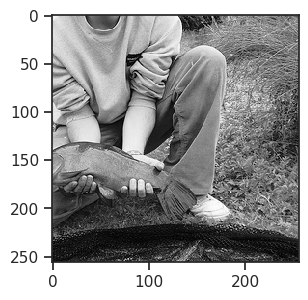

In [5]:
plt.imshow(to_np(x.squeeze())[3], cmap='Greys_r')
plt.show()

### Downsample to 32 x 32?

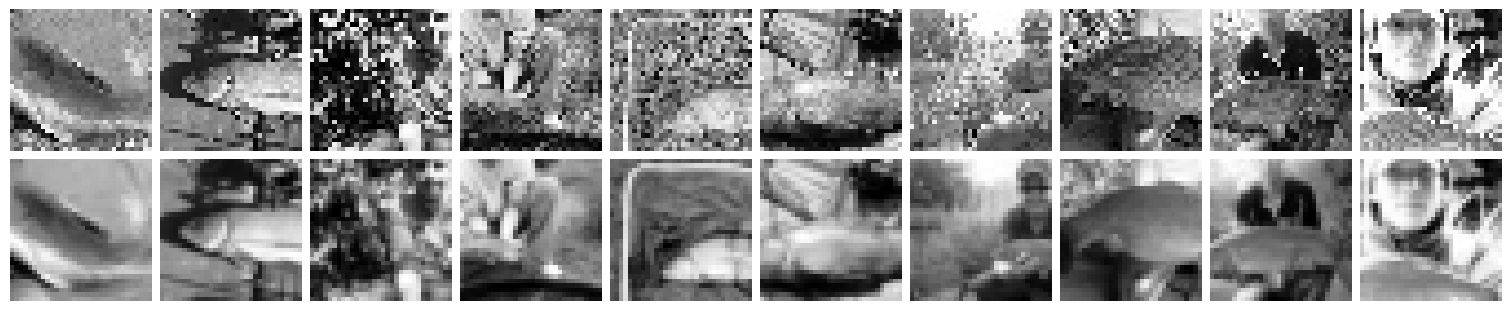

In [6]:
x_nearest = F.interpolate(x, size=(32, 32), mode='nearest')
x_bilinear = F.interpolate(x, size=(32, 32), mode='bilinear', antialias=True)

fig, axes = create_figure(2, 10, (15, 3.0), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x_nearest[i].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_bilinear[i].squeeze()), cmap='Greys_r')
remove_ticks(axes)
plt.show()

### FFT

In [7]:
%%time

psd = []

i = 0
_iter = iter(vld)

while i < len(vld):
    try:
        x, _ = next(_iter)
        psd.append(do_fft(x.cuda()))
    except (ValueError, StopIteration):
        pass
    i += 1

psd = np.concatenate(psd)
psd.shape

CPU times: user 1h 16min 53s, sys: 1min 23s, total: 1h 18min 16s
Wall time: 2min 26s


(27008, 128)

In [8]:
kvals = compute_fftfreq(npix)[1]
lin_reg = sp_stats.linregress(x=np.log(kvals), y=np.log(psd.mean(0)))
log_line = np.log(kvals) * lin_reg.slope + lin_reg.intercept

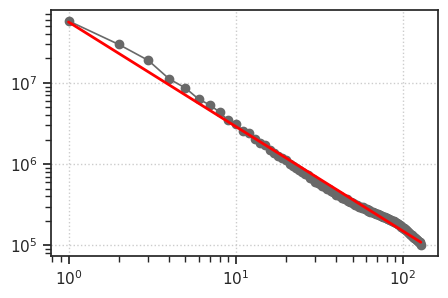

In [9]:
plt.loglog(kvals, psd.mean(0), marker='o', lw=1.2, color='dimgrey')
plt.loglog(kvals, np.exp(log_line), color='r', lw=2, ls='-')
plt.grid()
plt.show()

### Whitening / Contrast Normalization

Correct order:
1. Whitening
2. Local Contrast Normalization (LCN)
3. z score

In [10]:
whitener = Whitening((npix, npix), f_0=0.5, n=4, batched=True)
contrast_normalizer = LocContrastNorm(kernel_size=9, sigma=0.5, batched=True)

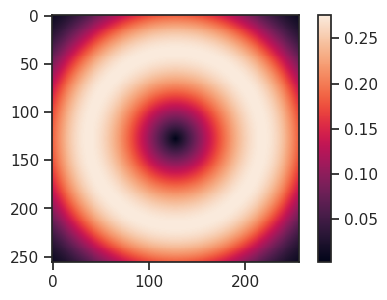

In [11]:
x, _ = next(iter(vld))
x_wt = whitener(x.cuda())
x_wt_cn = contrast_normalizer(x_wt)
x_wt_cn_zs = zscore(x_wt_cn)

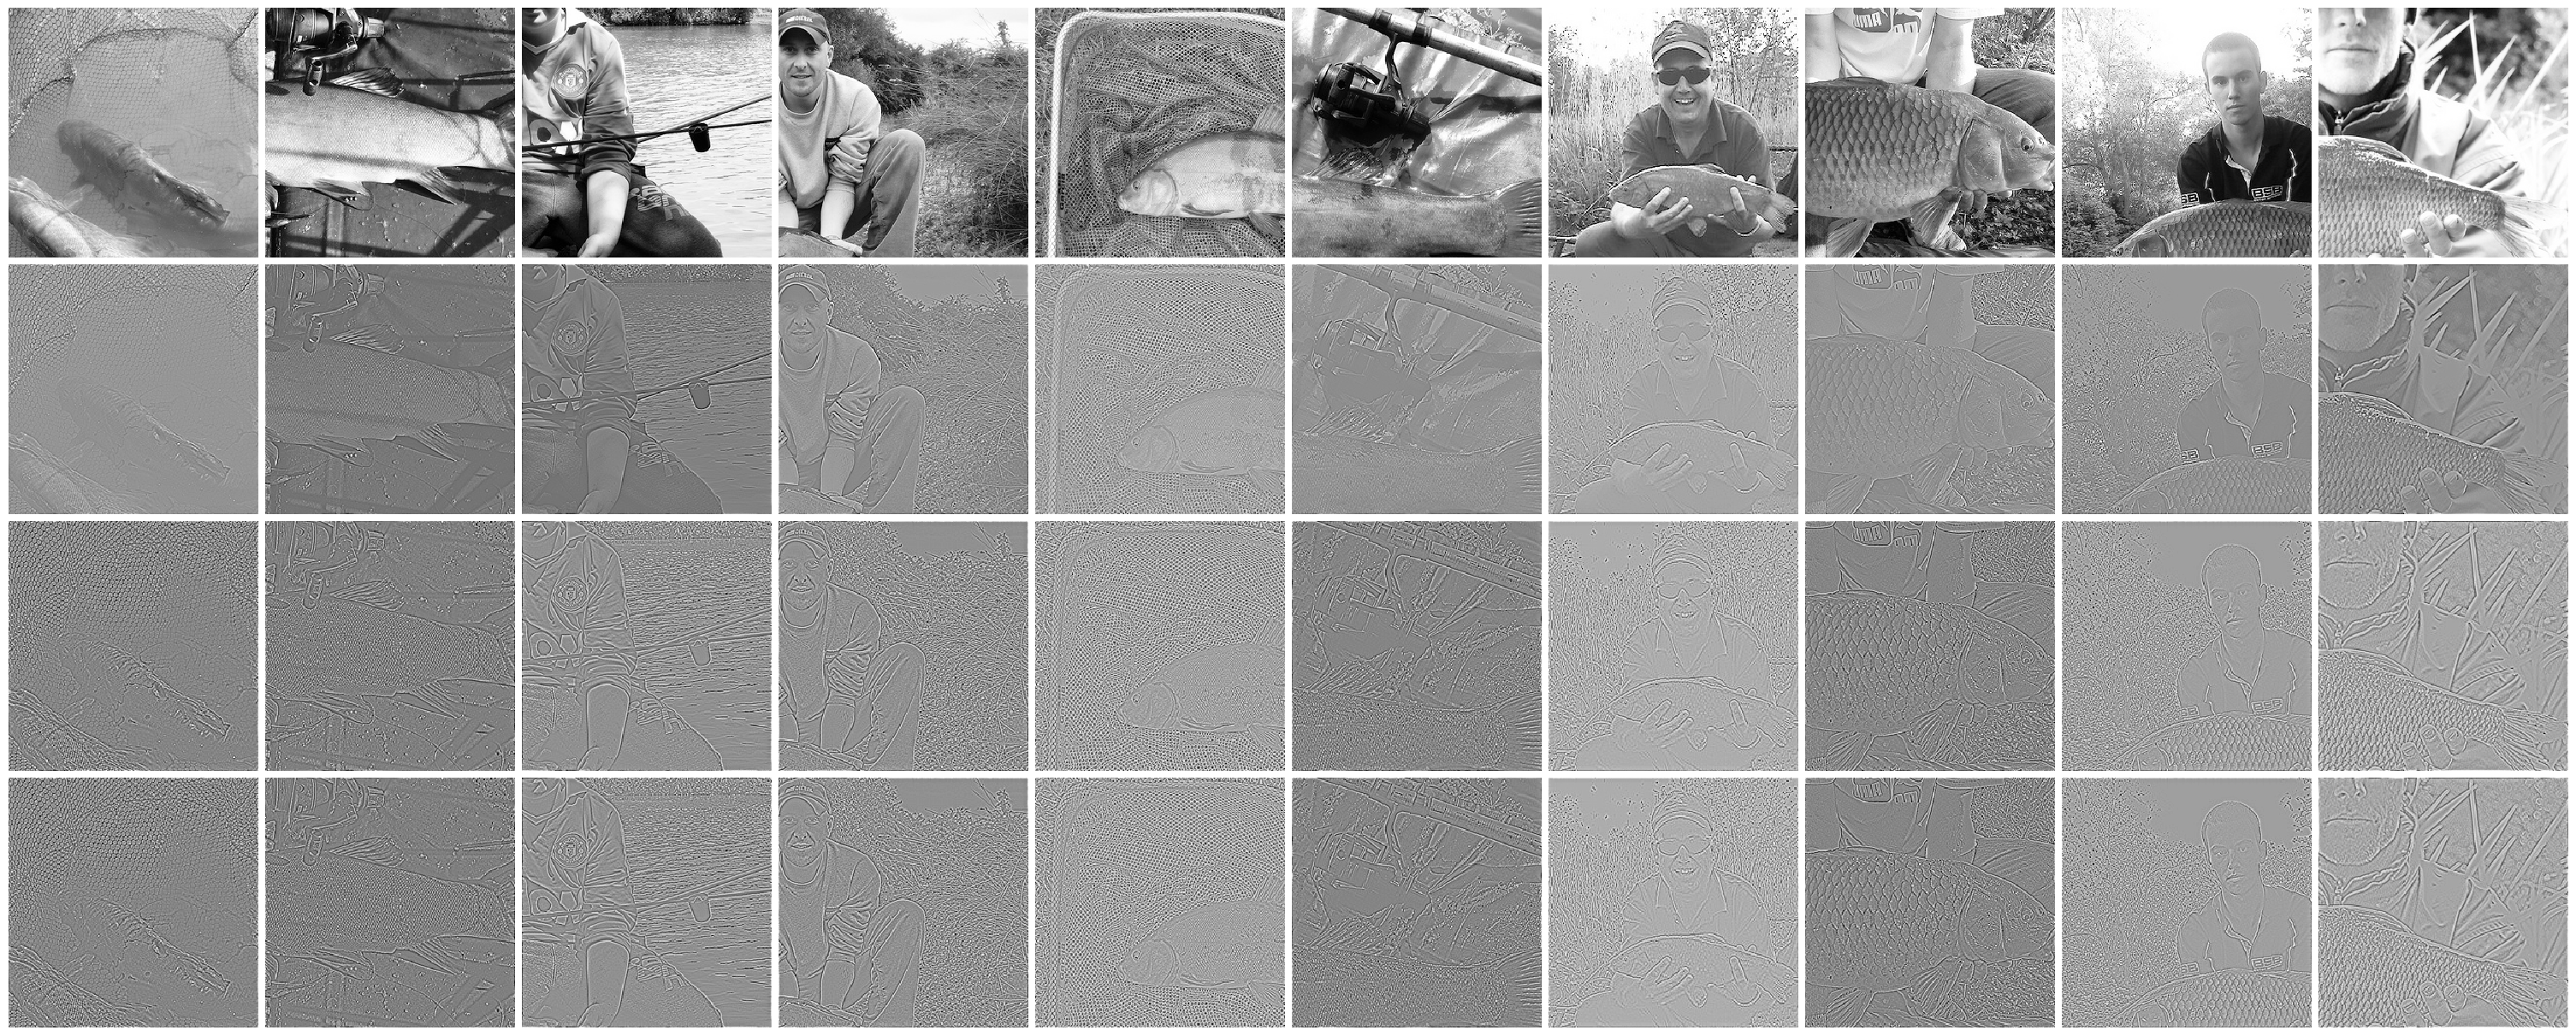

In [12]:
fig, axes = create_figure(4, 10, (30, 12.0), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i].squeeze()), cmap='Greys_r')
remove_ticks(axes)
plt.show()

## ImageNet ($32 \times 32$)

In [68]:
npix = 32
batch_size = 128
device = torch.device('cuda:1')

root = pjoin(os.environ['HOME'], 'Datasets', 'ImageNet')
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(npix),
    torchvision.transforms.Grayscale(),
    torchvision.transforms.ToTensor(),
])
kws = dict(root=root, transform=transform)

trn = torchvision.datasets.ImageNet(split='train', **kws)
vld = torchvision.datasets.ImageNet(split='val', **kws)

trn = DataLoader(dataset=trn, batch_size=batch_size, shuffle=True)
vld = DataLoader(dataset=vld, batch_size=batch_size, shuffle=False)

In [69]:
x, y = next(iter(vld))
x.shape

torch.Size([128, 1, 32, 32])

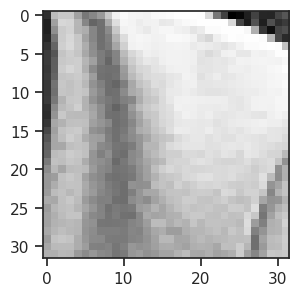

In [70]:
plt.imshow(to_np(x.squeeze())[3], cmap='Greys_r')
plt.show()

### FFT

In [16]:
%%time

psd = []

i = 0
_iter = iter(vld)

while i < len(vld):
    try:
        x, _ = next(_iter)
        psd.append(do_fft(x.cuda()))
    except (ValueError, StopIteration):
        pass
    i += 1

psd = np.concatenate(psd)
psd.shape

CPU times: user 2min 34s, sys: 1.98 s, total: 2min 36s
Wall time: 2min 36s


(50000, 16)

In [17]:
kvals = compute_fftfreq(npix)[1]
lin_reg = sp_stats.linregress(x=np.log(kvals), y=np.log(psd.mean(0)))
log_line = np.log(kvals) * lin_reg.slope + lin_reg.intercept

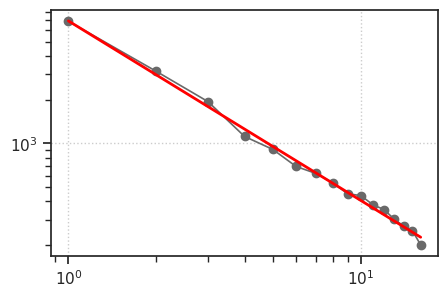

In [18]:
plt.loglog(kvals, psd.mean(0), marker='o', lw=1.2, color='dimgrey')
plt.loglog(kvals, np.exp(log_line), color='r', lw=2, ls='-')
plt.grid()
plt.show()

### Whitening / Contrast Normalization

In [19]:
whitener = Whitening((npix, npix), f_0=0.5, n=4, batched=True)
contrast_normalizer = LocContrastNorm(kernel_size=9, sigma=0.5, batched=True)

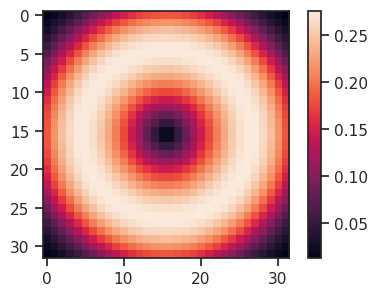

In [20]:
x, _ = next(iter(vld))
x_wt = whitener(x.cuda())
x_wt_cn = contrast_normalizer(x_wt)
x_wt_cn_zs = zscore(x_wt_cn)

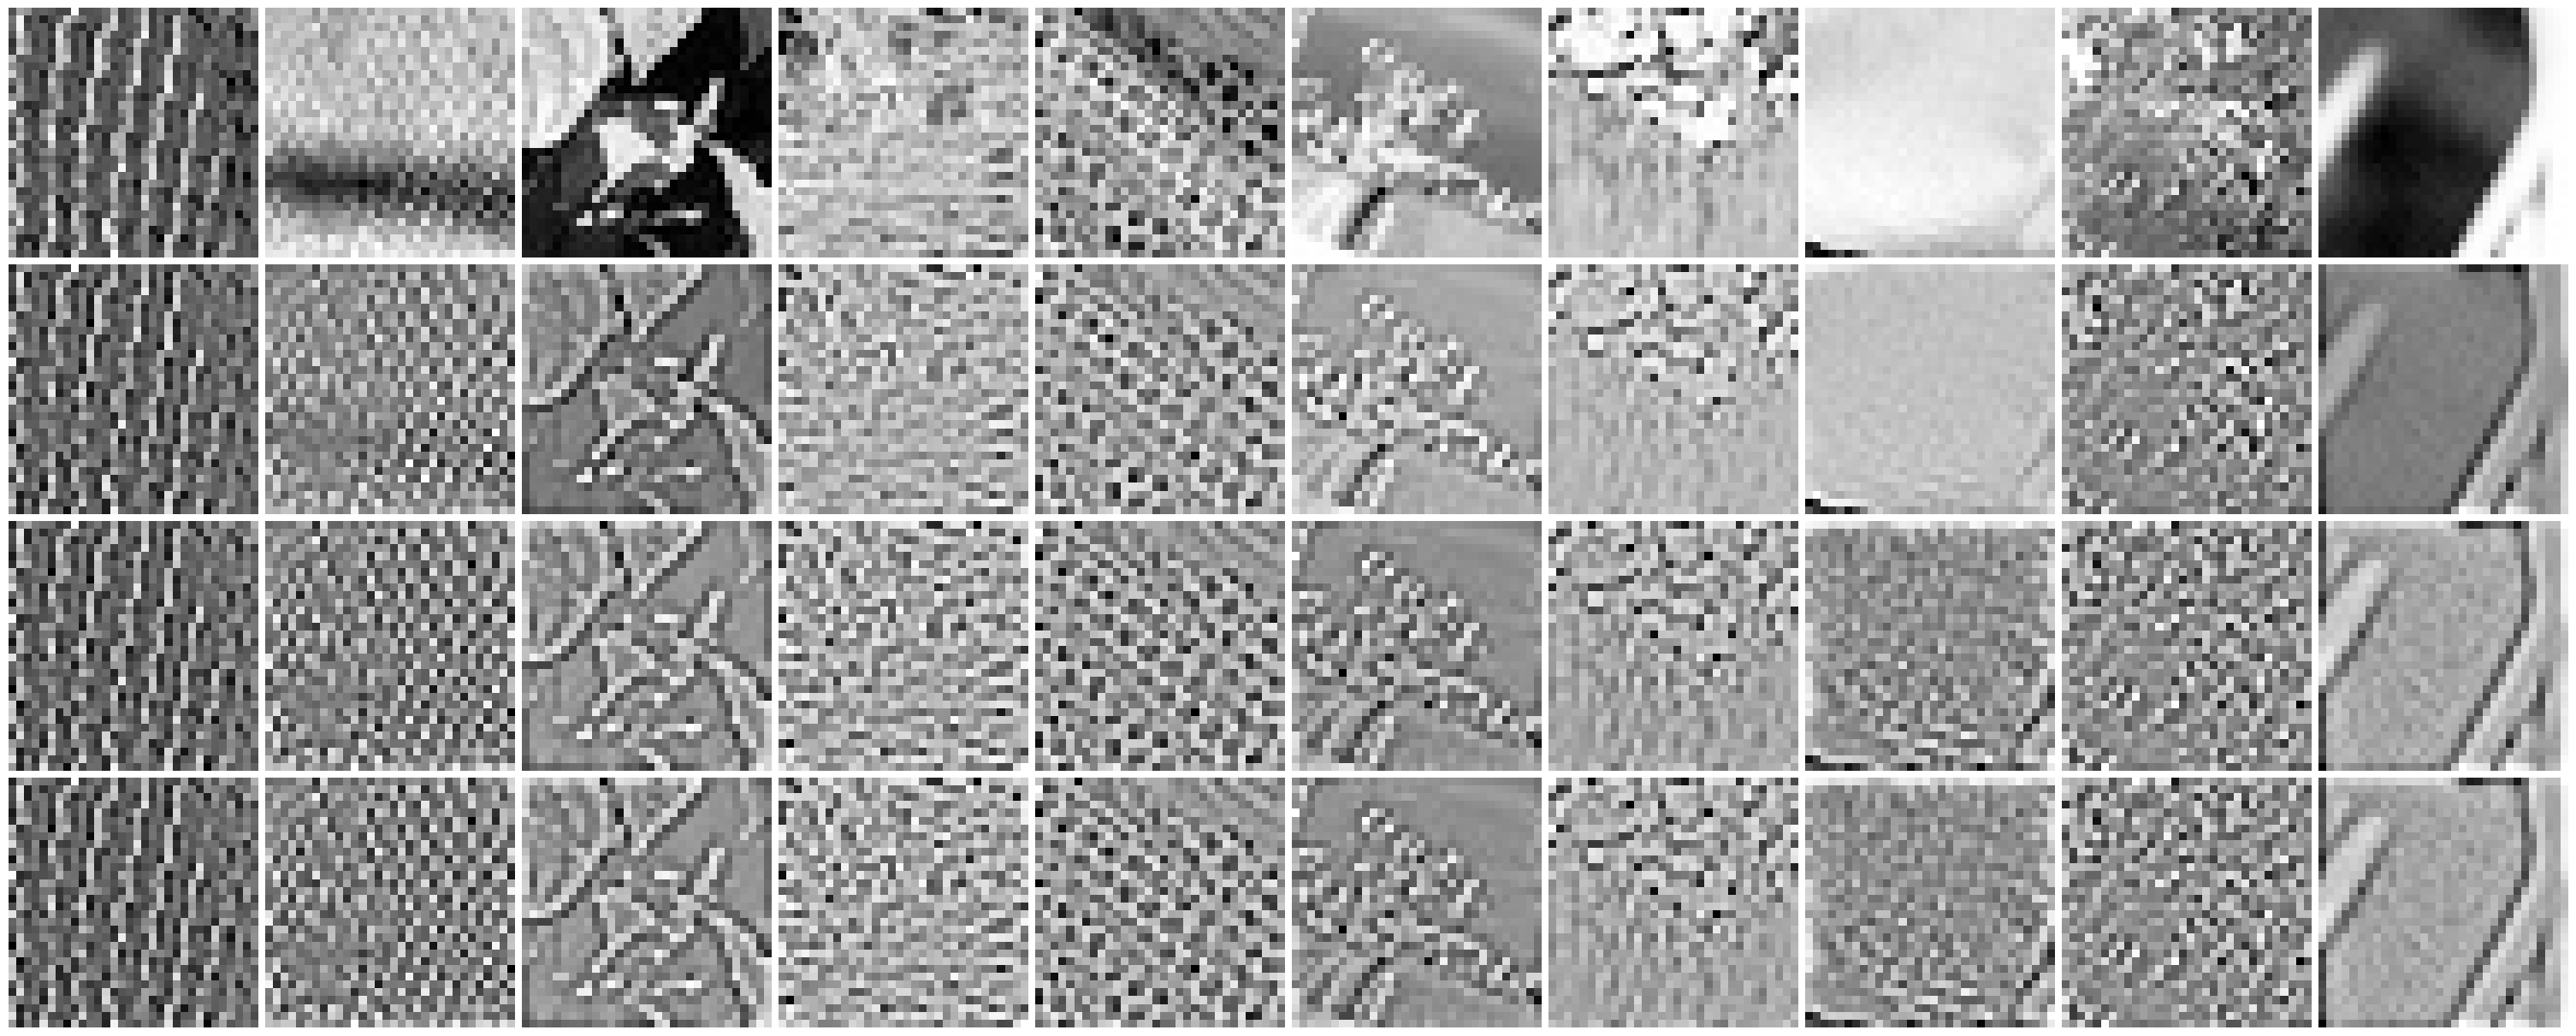

In [21]:
fig, axes = create_figure(4, 10, (30, 12.0), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i].squeeze()), cmap='Greys_r')
remove_ticks(axes)
plt.show()

## DOVES $(64 \times 64)$

In [3]:
npix = 64

doves = EyeDataset(10, 1, npix, npix)
whitener = Whitening((npix, npix), f_0=0.5, n=4, batched=True)
contrast_normalizer = LocContrastNorm(kernel_size=11, sigma=1.5, batched=True)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.44it/s]


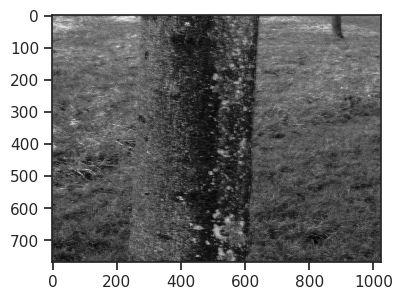

torch.Size([101, 1, 768, 1024])

In [4]:
plt.imshow(to_np(doves.imgs[44].squeeze()), cmap='Greys_r')
plt.show()

doves.imgs.shape

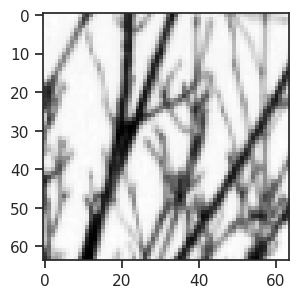

In [14]:
plt.imshow(to_np(doves.covariates['stim'].squeeze()[6, 180]), cmap='Greys_r');

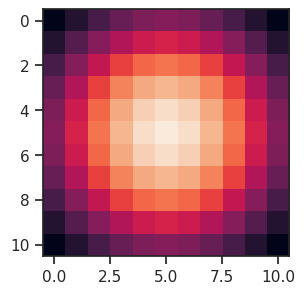

In [15]:
plt.imshow(to_np(contrast_normalizer.gaussian_k.squeeze()));

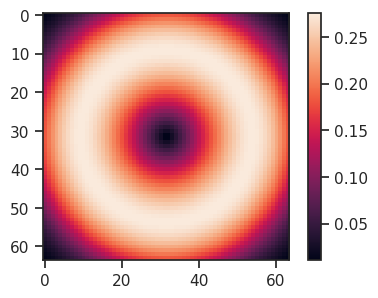

torch.Size([10, 1024, 1, 64, 64])

In [16]:
x = torch.flatten(doves.covariates['stim'], start_dim=0, end_dim=1)
x_wt = whitener(x.cuda())
x_wt_cn = contrast_normalizer(x_wt)
x_wt_cn_zs = zscore(x_wt_cn)

x, x_wt, x_wt_cn, x_wt_cn_zs = map(
    lambda t: t.reshape(doves.covariates['stim'].shape),
    [x, x_wt, x_wt_cn, x_wt_cn_zs]
)
x.shape

In [17]:
ncols = 10
ids = {
    i: np.random.choice(range(len(x[i])))
    for i in range(ncols)
}

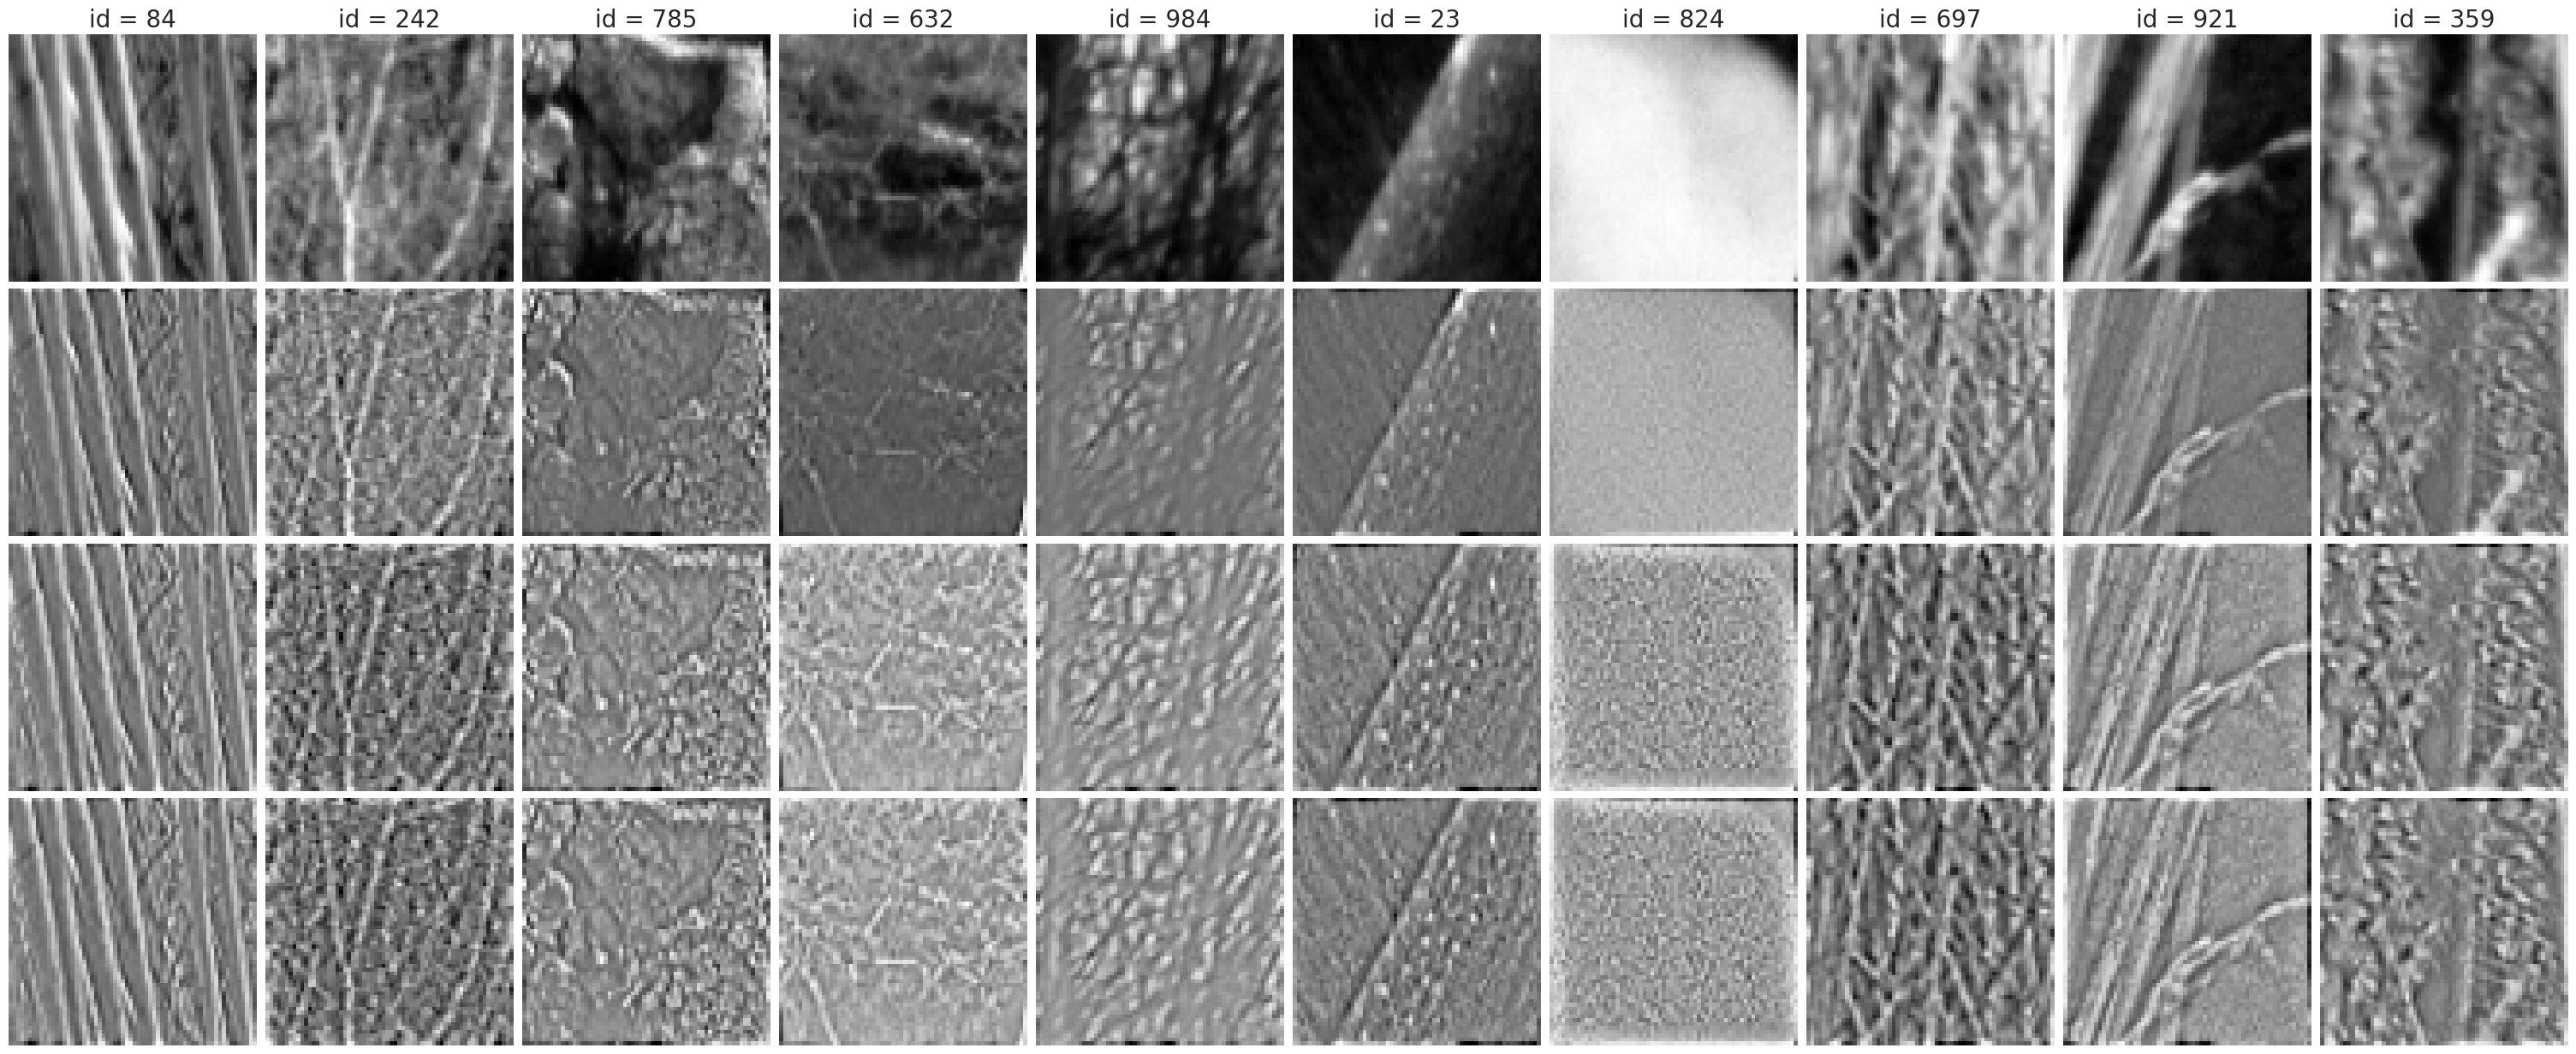

In [18]:
fig, axes = create_figure(4, ncols, (3.0 * ncols, 12.2), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[0, i].set_title(f"id = {ids[i]}", fontsize=20)
remove_ticks(axes)
plt.show()

## DOVES $(40 \times 40)$

In [36]:
npix = 40
doves = EyeDataset(10, 1, npix, npix)

whitener = Whitening((npix, npix), f_0=0.5, n=4, batched=True)
contrast_normalizer = LocContrastNorm(kernel_size=13, sigma=0.5, batched=True)

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  7.65it/s]


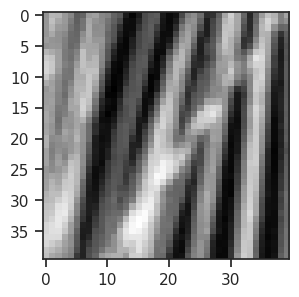

In [46]:
plt.imshow(to_np(doves.covariates['stim'].squeeze()[9, 270]), cmap='Greys_r');

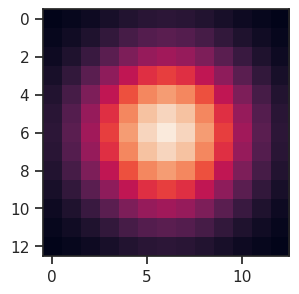

In [47]:
plt.imshow(to_np(contrast_normalizer.gaussian_k.squeeze()));

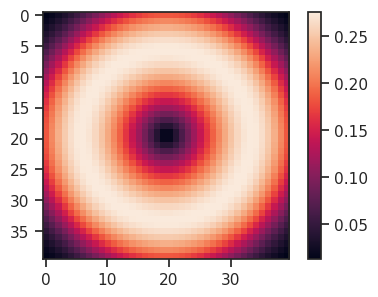

torch.Size([10, 1024, 1, 40, 40])

In [48]:
x = torch.flatten(doves.covariates['stim'], start_dim=0, end_dim=1)
x_wt = whitener(x.cuda())
x_wt_cn = contrast_normalizer(x_wt)
x_wt_cn_zs = zscore(x_wt_cn)

x, x_wt, x_wt_cn, x_wt_cn_zs = map(
    lambda t: t.reshape(doves.covariates['stim'].shape),
    [x, x_wt, x_wt_cn, x_wt_cn_zs]
)
x.shape

In [49]:
ncols = 10
ids = {
    i: np.random.choice(range(len(x[i])))
    for i in range(ncols)
}

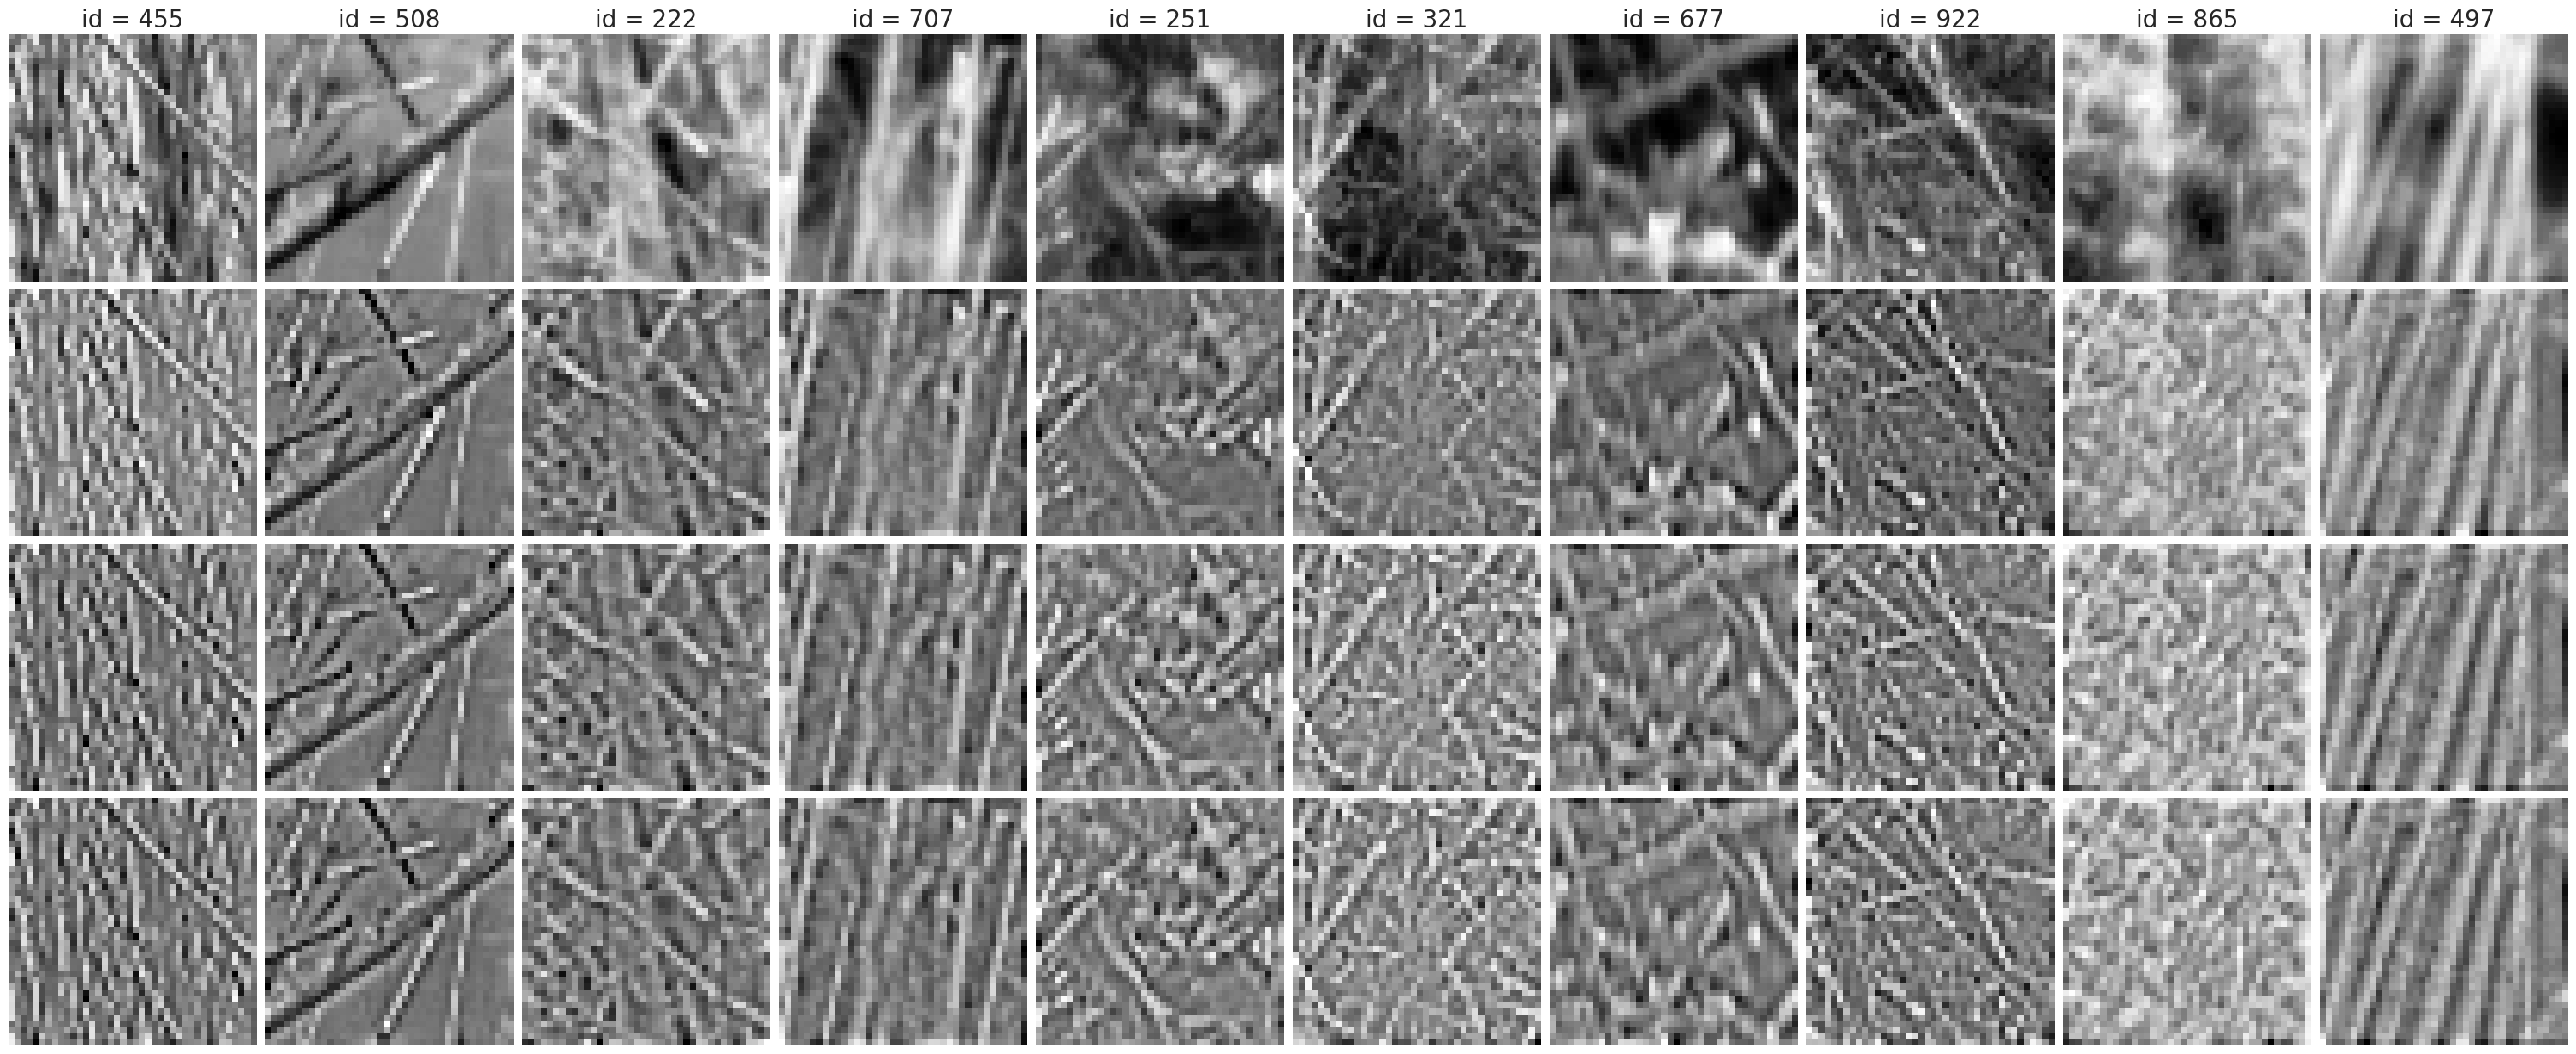

In [50]:
fig, axes = create_figure(4, ncols, (3.0 * ncols, 12.2), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[0, i].set_title(f"id = {ids[i]}", fontsize=20)
remove_ticks(axes)
plt.show()

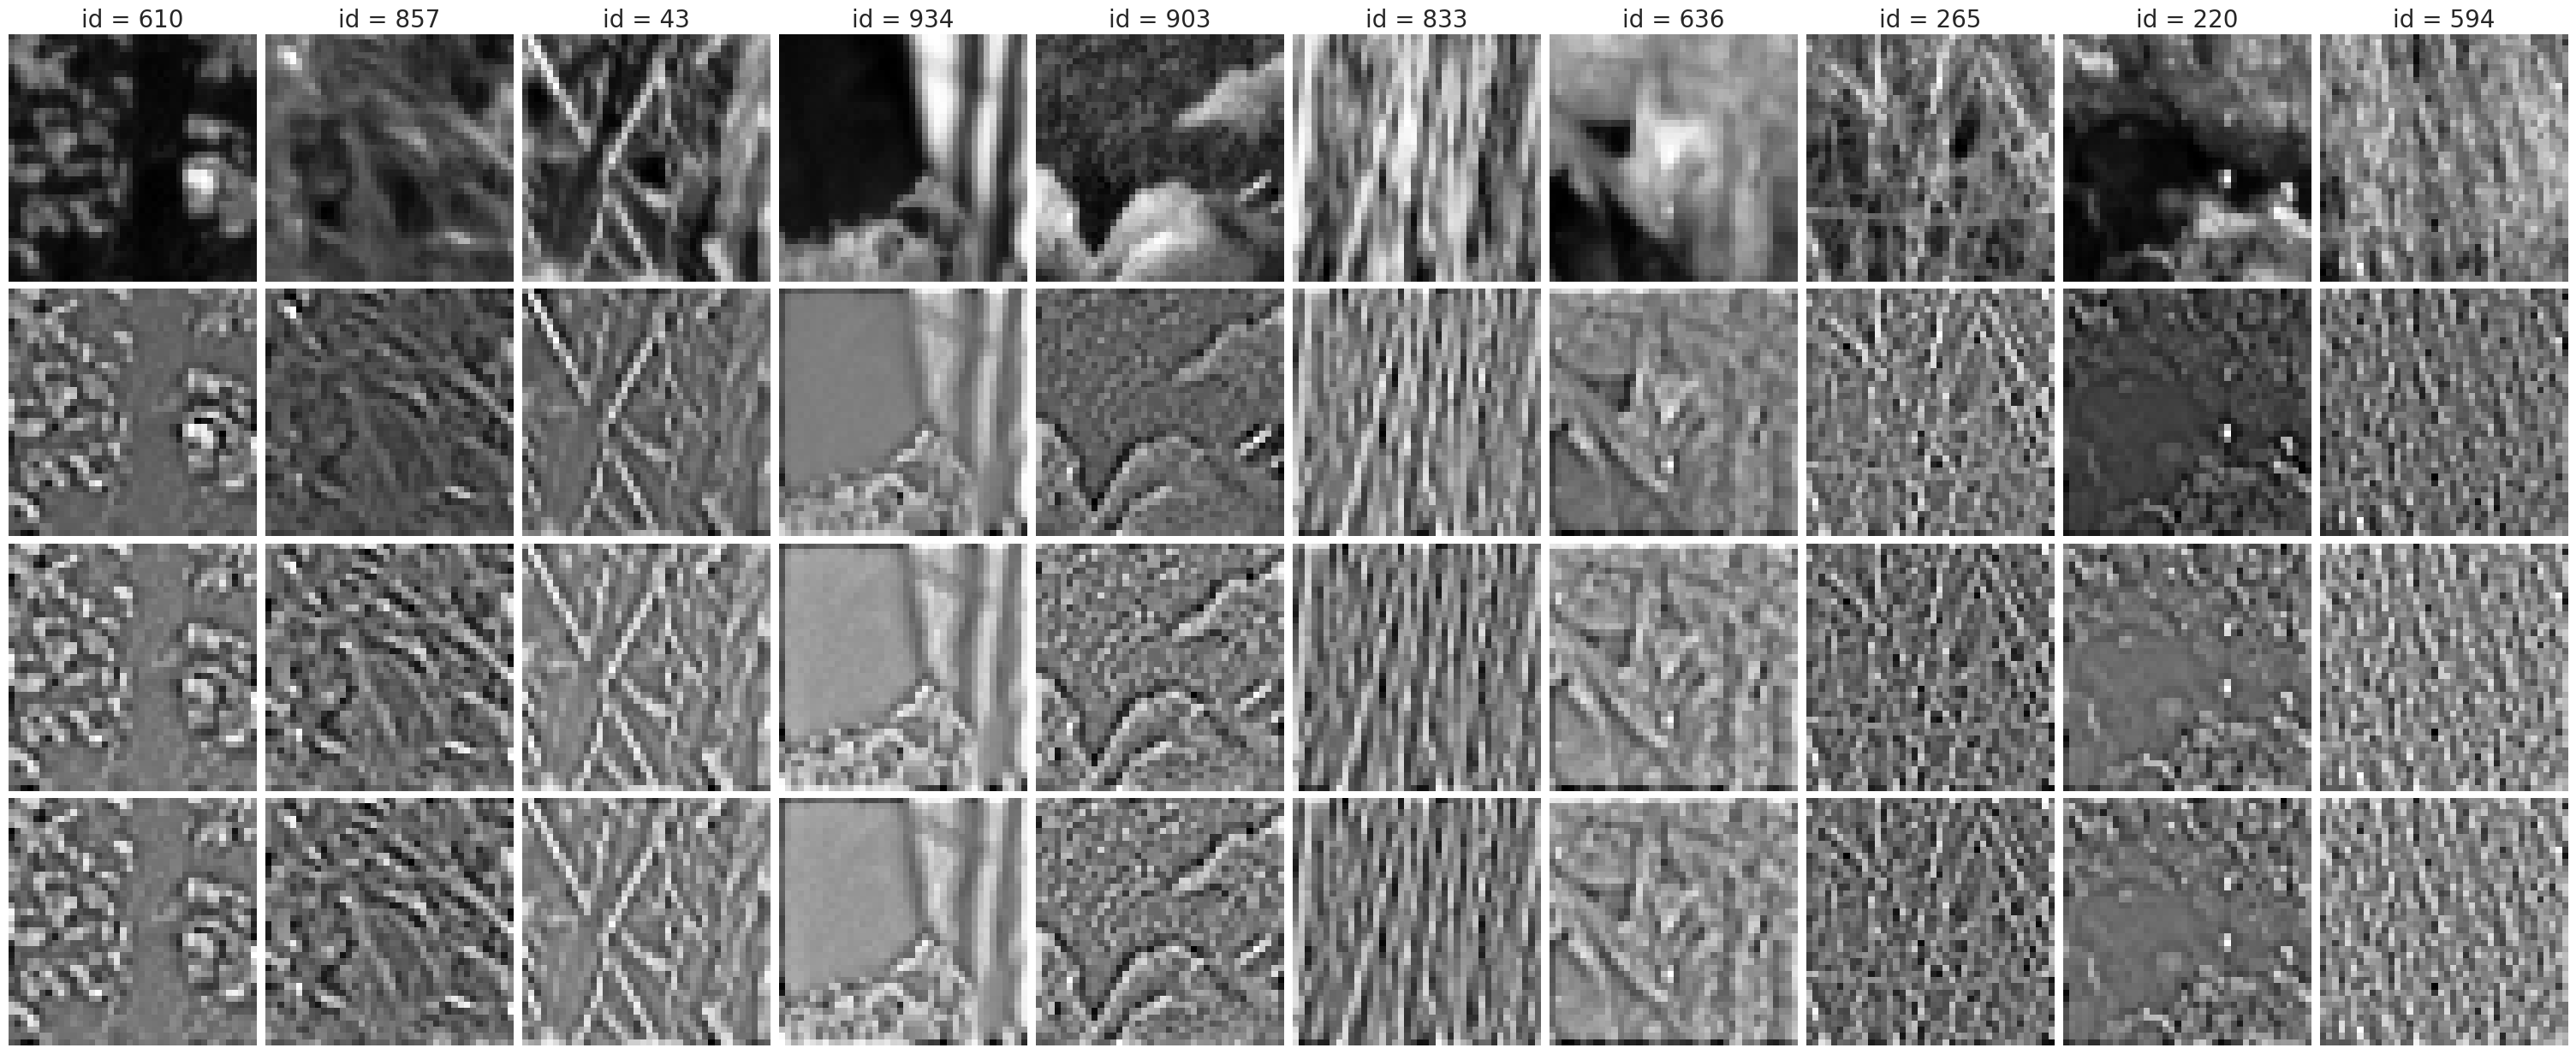

### Crop center

In [51]:
x, x_wt, x_wt_cn, x_wt_cn_zs = map(
    lambda t: t[..., 4:-4, 4:-4],
    [x, x_wt, x_wt_cn, x_wt_cn_zs]
)
x.shape

torch.Size([10, 1024, 1, 32, 32])

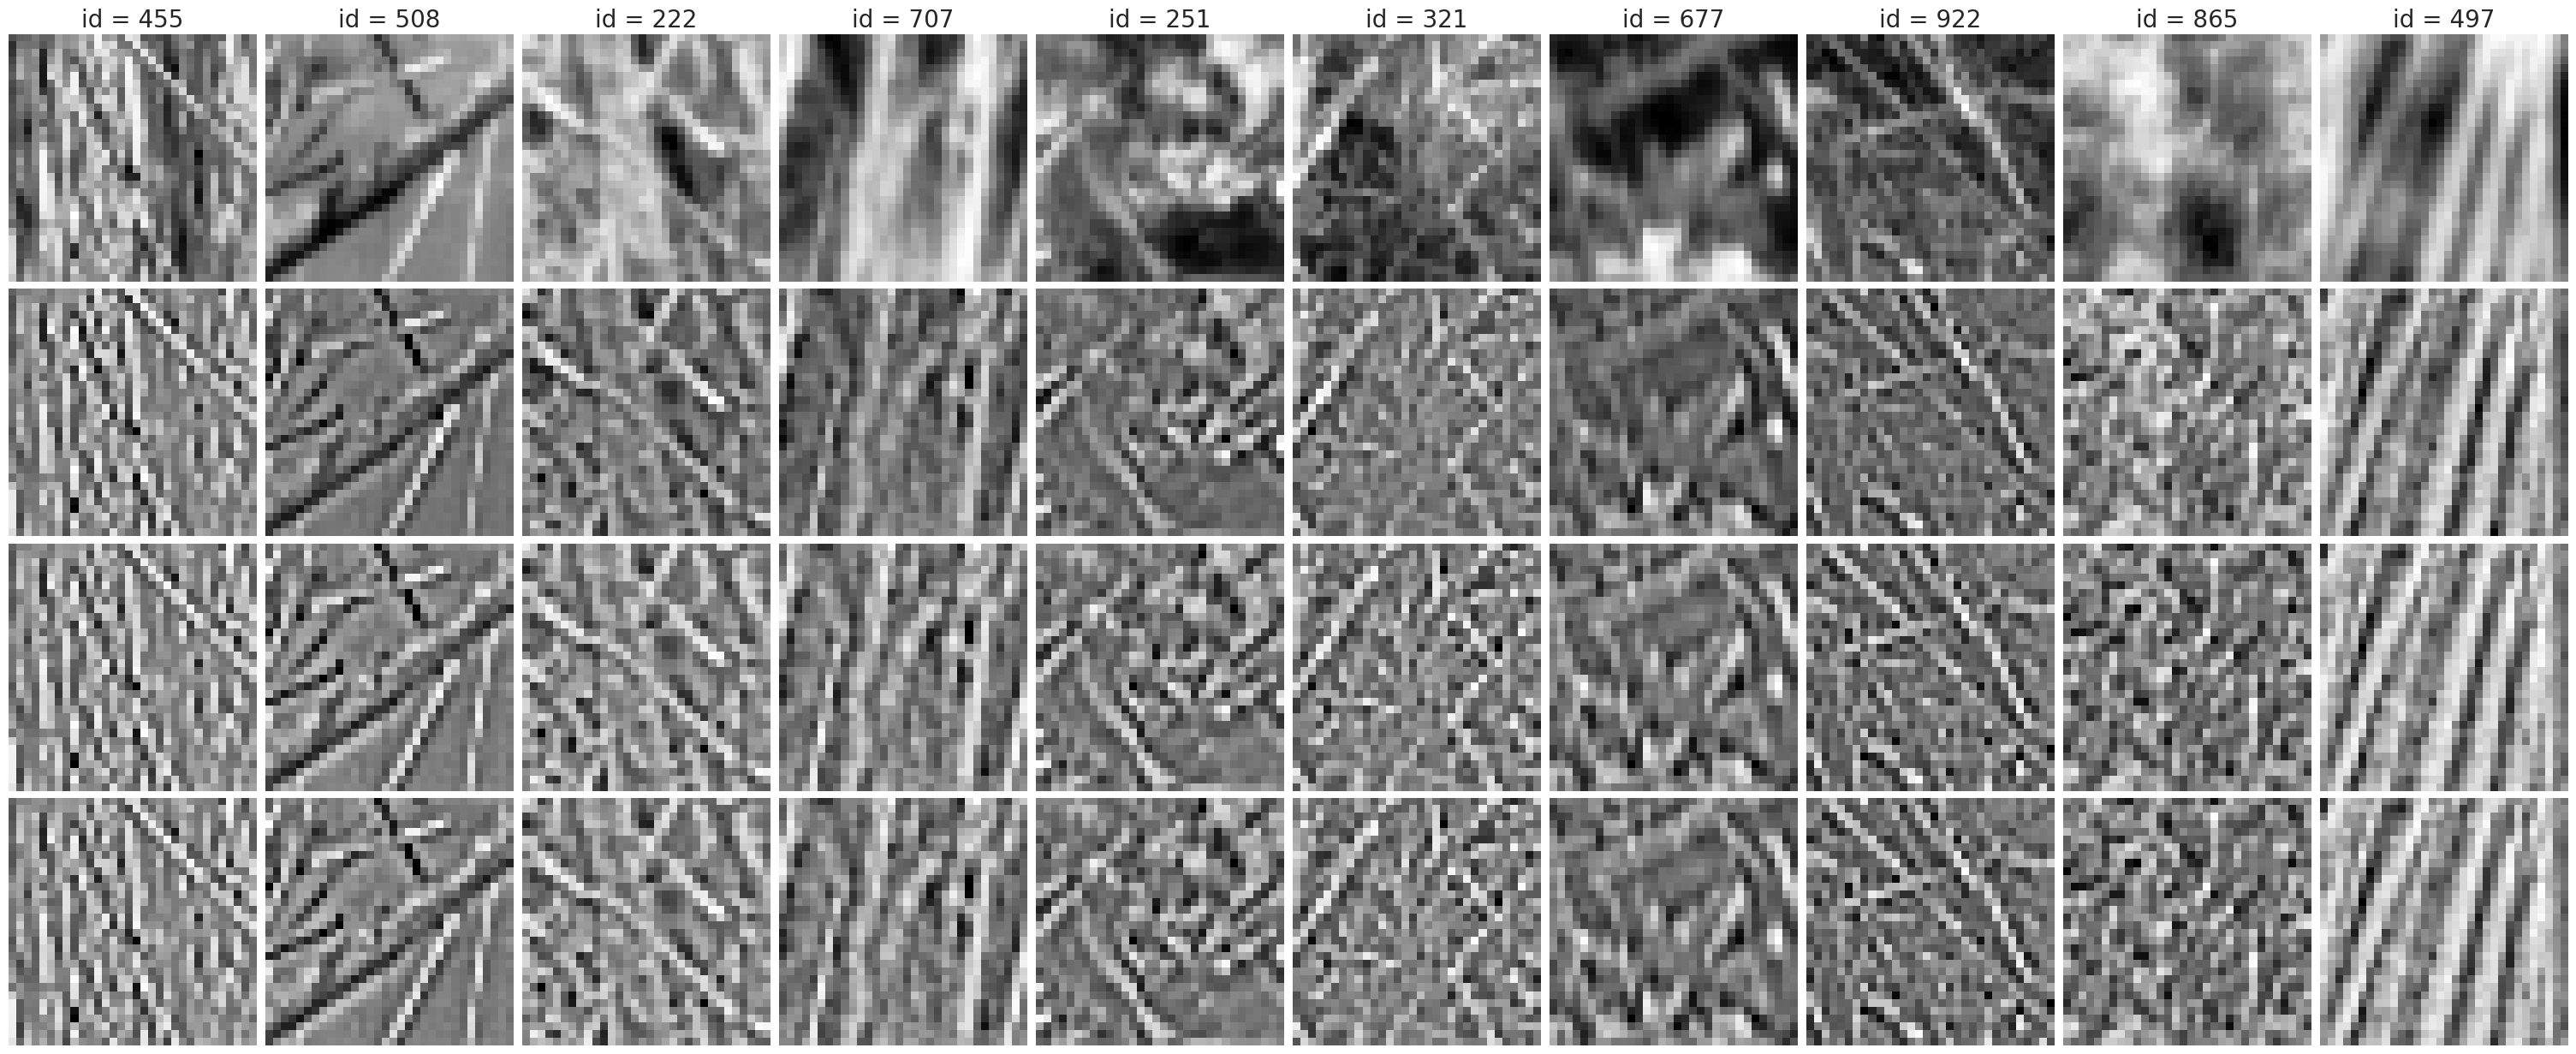

In [52]:
fig, axes = create_figure(4, ncols, (3.0 * ncols, 12.2), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[0, i].set_title(f"id = {ids[i]}", fontsize=20)
remove_ticks(axes)
plt.show()

## DOVES / FFT

In [3]:
%%time

npix = 40
doves = EyeDataset(100, 5, grid_w=npix, grid_h=npix)

whitener = Whitening((npix, npix), f_0=0.5, n=4, batched=True)
contrast_normalizer = LocContrastNorm(kernel_size=13, sigma=0.5, batched=True)

100%|█████████████████████████████████████████| 500/500 [01:04<00:00,  7.74it/s]


CPU times: user 33min 56s, sys: 41.2 s, total: 34min 37s
Wall time: 1min 5s


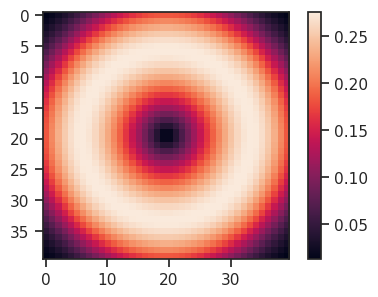

torch.Size([500, 1024, 1, 40, 40])

In [4]:
x = torch.flatten(doves.covariates['stim'], start_dim=0, end_dim=1)
x_wt = whitener(x.cuda())
x_wt_cn = contrast_normalizer(x_wt)
x_wt_cn_zs = zscore(x_wt_cn)

x, x_wt, x_wt_cn, x_wt_cn_zs = map(
    lambda t: t.reshape(doves.covariates['stim'].shape),
    [x, x_wt, x_wt_cn, x_wt_cn_zs]
)
x.shape

In [5]:
x, x_wt, x_wt_cn, x_wt_cn_zs = map(
    lambda t: t[..., 4:-4, 4:-4],
    [x, x_wt, x_wt_cn, x_wt_cn_zs]
)
x.shape

torch.Size([500, 1024, 1, 32, 32])

In [8]:
ncols = 10
ids = {
    i: np.random.choice(range(len(x[i])))
    for i in range(ncols)
}

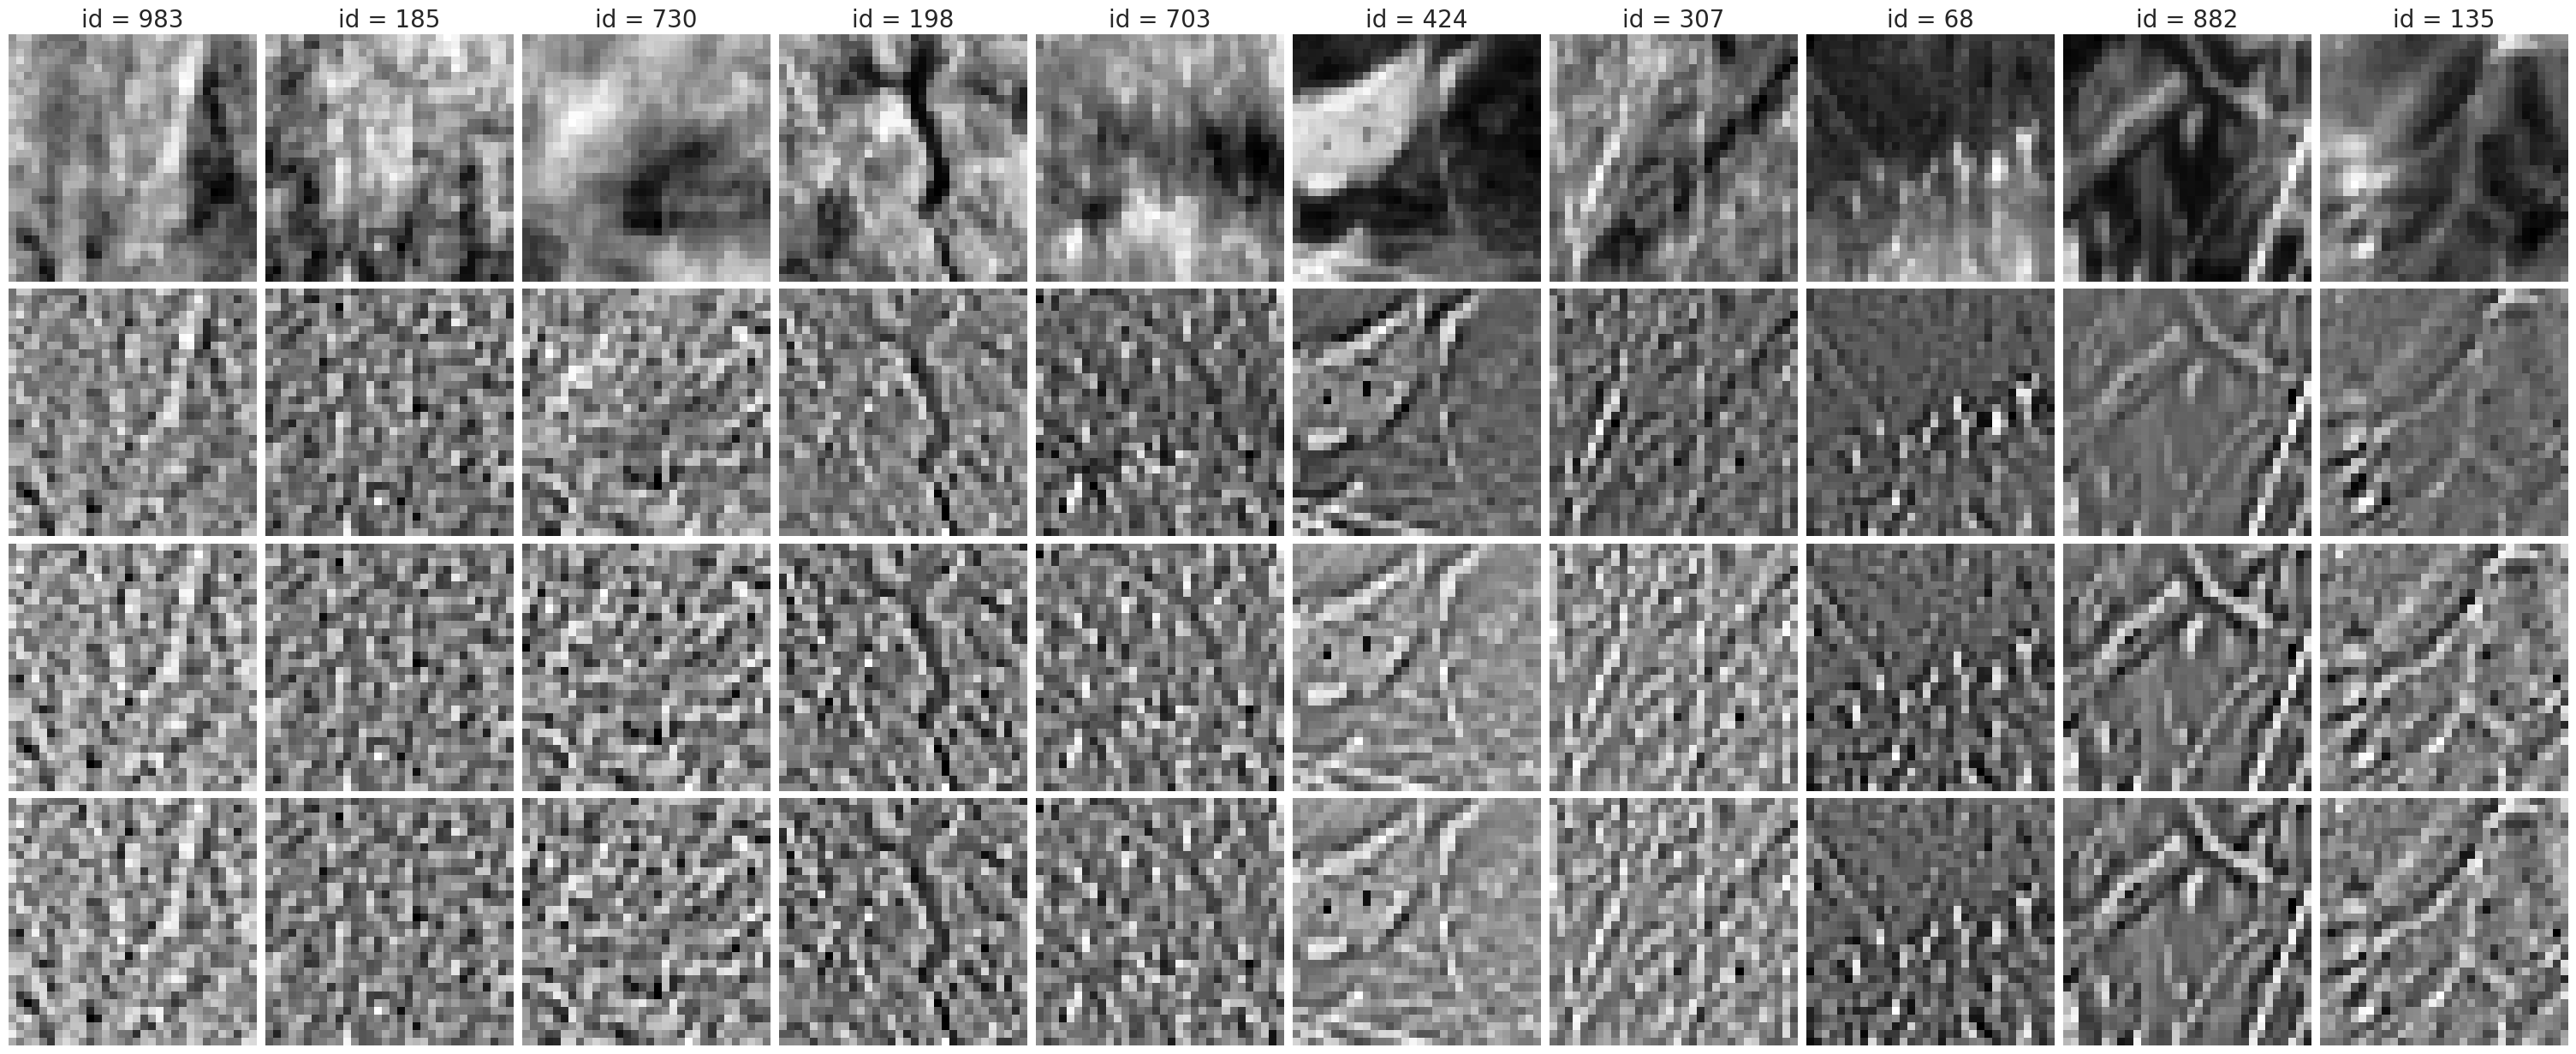

In [9]:
fig, axes = create_figure(4, ncols, (3.0 * ncols, 12.2), 'all', 'all', layout='constrained')
for i in range(10):
    axes[0, i].imshow(to_np(x[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[1, i].imshow(to_np(x_wt[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[2, i].imshow(to_np(x_wt_cn[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[3, i].imshow(to_np(x_wt_cn_zs[i, ids[i]].squeeze()), cmap='Greys_r')
    axes[0, i].set_title(f"id = {ids[i]}", fontsize=20)
remove_ticks(axes)
plt.show()

### FFT

In [10]:
%%time

psd = do_fft(torch.flatten(x_wt_cn_zs, start_dim=0, end_dim=1))
psd.shape

CPU times: user 44.9 s, sys: 372 ms, total: 45.3 s
Wall time: 45.3 s


(512000, 16)

In [28]:
good = np.isnan(psd).sum(1) == 0
len(psd) - good.sum()

1100

In [29]:
kvals = compute_fftfreq(x.shape[-1])[1]
lin_reg = sp_stats.linregress(x=np.log(kvals), y=np.log(psd[good].mean(0)))
log_line = np.log(kvals) * lin_reg.slope + lin_reg.intercept

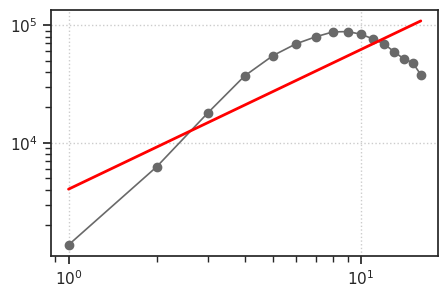

In [31]:
plt.loglog(kvals, psd[good].mean(0), marker='o', lw=1.2, color='dimgrey')
plt.loglog(kvals, np.exp(log_line), color='r', lw=2, ls='-')
plt.grid()
plt.show()

In [32]:
lin_reg

LinregressResult(slope=1.1858503033564831, intercept=8.307583361771956, rvalue=0.8290967153864935, pvalue=7.174232745051622e-05, stderr=0.21372444416312295, intercept_stderr=0.4410552272047082)